In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/train.csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

### 1.概要（Overview）

トレーニングデータは1460件、テストデータも1460件あります。
属性（特徴量）の総数は81個で、そのうち 36個が量的（quantitative）特徴量、43個がカテゴリ（categorical）特徴量、さらに IdとSalePrice を含みます。


### 2.量的特徴量（Quantitative）:

1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2,
BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces,
FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath,
KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea,
MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea,
ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold


### 3.カテゴリ特徴量（Qualitative）:

Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2,
BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond,
ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation,
Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating,
HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig,
LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive,
PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities

In [2]:
missing = train.isnull().sum()

- train.isnull()：train データフレーム内の欠損値（NaN）をTrue、それ以外をFalseとするマスクを作成。

- .sum()：各列ごとに True の数（= 欠損値の個数）を合計。

### 4.欠損値

In [3]:
missing = missing[missing > 0]

- 欠損値が1つ以上ある列だけに絞り込み。

- 欠損が0の列は無視して、分析に不要な情報を削除。

<Axes: >

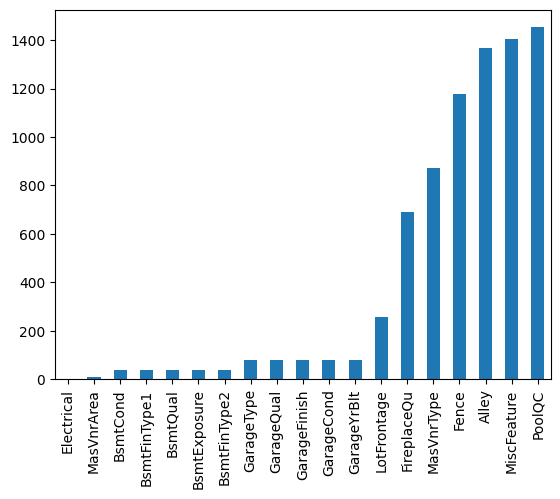

In [4]:
missing.sort_values(inplace=True)
missing.plot.bar()

19個の属性に欠損値があり、そのうち5つは全データの50%以上が欠損しています。
多くの場合、NA（欠損値）はその属性で表される対象が存在しないことを意味します。
例えば、プールやフェンスがない、ガレージや地下室がないといったケースです。

### 5.目的変数の分布

In [5]:
import scipy.stats as st
y = train['SalePrice']

- scipy.stats を st としてインポート。
- 各種確率分布（正規分布、対数正規分布、Johnson SU分布など）にアクセスできるようにします。



C:\Users\tatib\AppData\Local\Temp\ipykernel_18000\1515662550.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=st.johnsonsu)
C:\Users\tatib\AppData\Local\Temp\ipykernel_18000\1515662550.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=st.norm)
C:\Users\ta

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

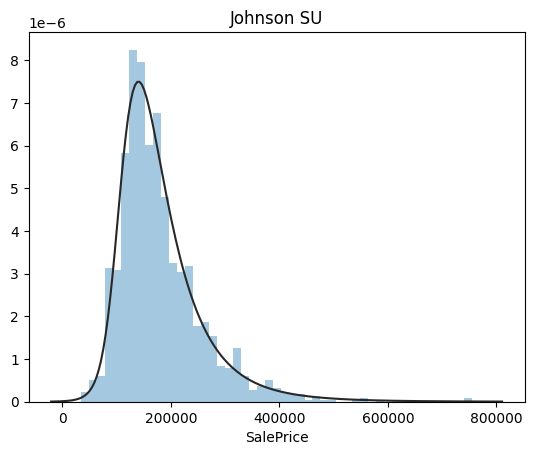

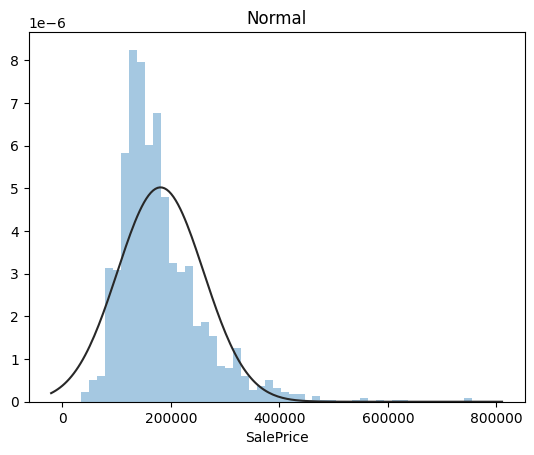

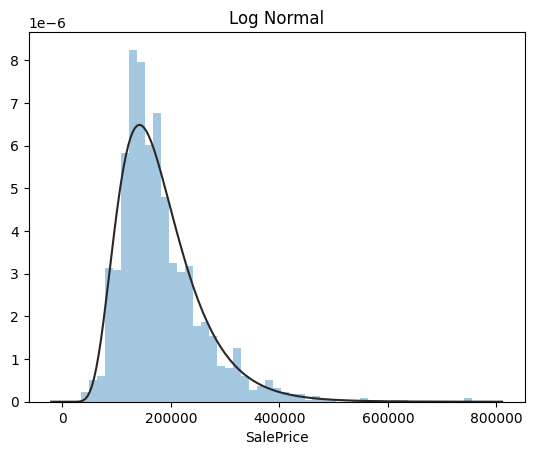

In [6]:
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

- plt.figure(1)：1つ目のプロットウィンドウを作成。

- plt.title('Johnson SU')：タイトルを設定。

- sns.distplot(...)：y のヒストグラムを描画（kde=False でカーネル密度推定は無効）fit=st.johnsonsu で、Johnson SU分布にフィッティングされたカーブを表示。

SalePrice（販売価格）が正規分布に従っていないことは明らかなので、回帰分析を行う前に変換が必要です。
**対数変換（log transformation）**はかなりうまく機能しますが、最も適合するのは非有界の Johnson 分布です。

### 正規性の検定（シャピロ・ウィルク検定）

In [7]:

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01

stats.shapiro(x.fillna(0))：
- シャピロ・ウィルク検定を実行。
- 欠損値は０で埋めてから検定
- 戻り値は（統計量、ｐ値）のタプル
[1] < 0.01:p値が0.01未満なら正規分布でないと判断（優位水準１％）

In [8]:
normal = pd.DataFrame(train[quantitative])

normal = pd.DataFrame(train[quantitative])：数値特徴量だけ取り出して、DataFrame normal を作成。

In [9]:
normal = normal.apply(test_normality)

normal = normal.apply(test_normality)：
- 各数値列に対して test_normality を適用（列ごとのシャピロ検定）。
- 結果は True/False の Series（True ＝正規分布に従っていない）。

In [10]:
print(not normal.any())

False


not normal.any()：

- 全ての数値列が正規分布に従っているなら True

- 1つでも従っていない列があれば False

また、どの量的変数（quantitative variables）も正規分布に従っていないため、これらも変換（transform）する必要があります。

In [11]:
f = pd.melt(train, value_vars=quantitative)

f = pd.melt(train, value_vars=quantitative):
- pd.melt() は「列を縦長に変換（long形式に変換）」する関数。
- value_vars=quantitative：量的変数（数値特徴量）だけを変換対象とする。
- 変換後は、以下のような形のDataFrameになります：


In [12]:
print(f)

         variable   value
0      MSSubClass    60.0
1      MSSubClass    20.0
2      MSSubClass    60.0
3      MSSubClass    70.0
4      MSSubClass    60.0
...           ...     ...
52555      YrSold  2007.0
52556      YrSold  2010.0
52557      YrSold  2010.0
52558      YrSold  2010.0
52559      YrSold  2008.0

[52560 rows x 2 columns]


![]('./img/image.png')

c:\Users\tatib\EDA\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\tatib\EDA\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\tatib\EDA\.venv\Lib\s

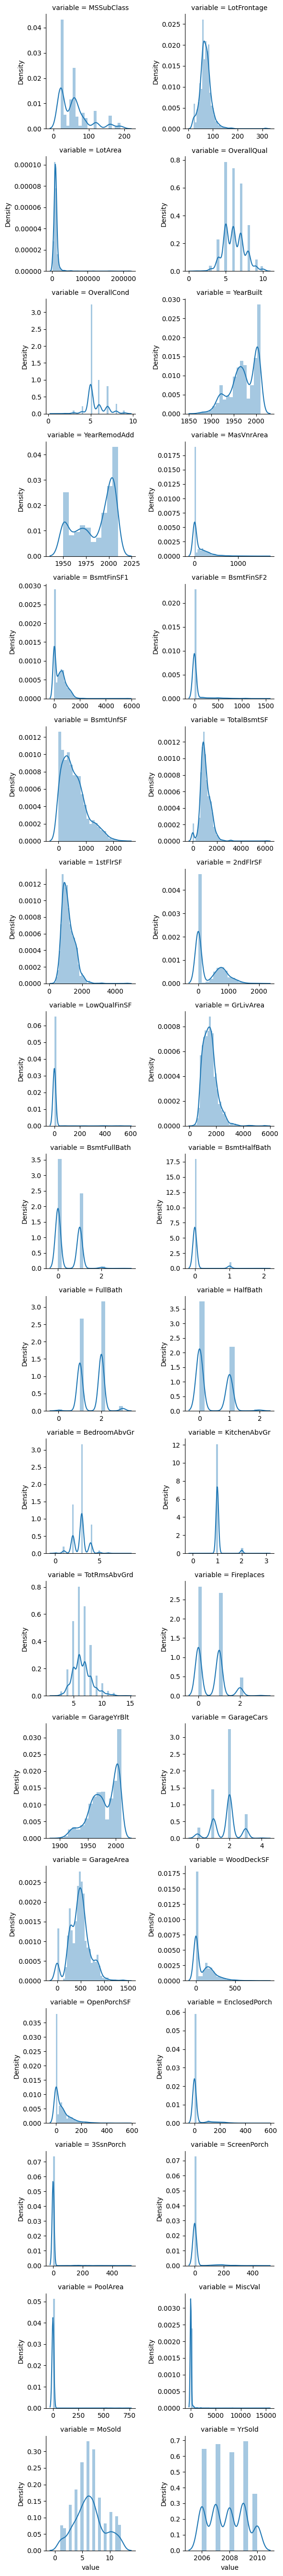

In [13]:
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False):

- Seaborn の FacetGrid を使って複数グラフを描画する準備をします。

- col="variable"：variable（変数名）ごとに個別のグラフを作成。

- col_wrap=2：2列に折り返して並べる。

- sharex=False, sharey=False：それぞれのグラフで x軸・y軸を独立させる。



いくつかの独立変数は、対数変換（log transformation）に適した候補に見えます。
たとえば、TotalBsmtSF（地下の総面積）、KitchenAbvGr（地上階のキッチン数）、LotFrontage（敷地の間口）、LotArea（敷地面積）などです。

一方で、回帰モデルに有利なように変換を行うことで、2階がない住宅が多い（2ndFlrSF が 0 の件数が多い）といった不規則なパターンが平滑化されてしまう可能性があります。

こうした不規則性は、新しい特徴量の構築（feature construction）に適した情報源となり得ます。

### Categorical Data

### 相関係数

一般的に、交絡（confounding）を減らすためには、互いに相関していない変数だけを回帰モデルに加えるべきです（ただし、それらは SalePrice と相関している必要があります）。

In [14]:
def spearman(frame,features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'],'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features = quantitative + qual_encoded

spearman(train, features)
    

NameError: name 'qual_encoded' is not defined

### Price Segments

SalePrice（販売価格）の変化に伴い、相関関係が変化する可能性があります。

In [ ]:
# uantitative は数値型の特徴量のリスト
features = quantitative

# データ分割
standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

# 各特徴量について、differenceの値を棒として計算
sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

- `fillna(0.)`：
  - 欠損値を 0 に置き換えています（欠損を無視せずに平均を取るため）。

- `(pricey[f].mean() - standard[f].mean()) / standard[f].mean()`：
  - 各特徴量 `f` における高価格帯と低価格帯の **相対的な平均の違い** を求めています。
  - 式は、以下のような **相対誤差（relative error）** に近い：

  $$
  \text{difference} = \frac{\text{高価格帯平均} - \text{低価格帯平均}}{\text{低価格帯平均}}
  $$


ここでは住宅を2つの価格帯に分けています：安価（20万未満）と高価。それから数値変数の平均を比較しています。高価格帯の住宅はプールがあり、全体的な品質と状態が良く、オープンポーチがあり、MasVnrArea（石材ベニア面積）の重要性が高まっています。



### Clustering

In [ ]:
features = quantitative + qual_encoded

### Regression

In [ ]:
def error(actual,predicted):
    """
    対数スケールでのRMSE(Root Mean Squared Error)を計算する。 
    """
    actual = np.log(actual)
    predicted  = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual - predicted)) / len(actual))

np.log(actual)：

- 実測値に対して自然対数（log𝑒）を取る。

- 0以下の値があるとエラーになるので、前処理で回避が必要です。

np.square(actual - predicted)：

- 対数スケールでの差を2乗します。

np.sqrt(...)：

- 二乗誤差の平均を取ったあと平方根をとることで、RMSEに変換します。

In [ ]:
def log_transform(feature):
    """"
    指定した feature(列)に対して、log(1 + x) の変換を適用します。
    分布が歪んだデータ（右に偏っているような場合）を正規分布に近づけるために使われます。
    """
    train[feature] = np.log1p(train[feature].values)

In [ ]:
def quadratic(feature):
    """"
    指定した特徴量 feature に対して、その 2乗の特徴量 を新たに作成し、列として追加します。
    非線形な関係 をモデルに取り入れるために使われる。
    """
    train[feature+'2'] = train[feature]**2

In [ ]:
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')
